<a href="https://colab.research.google.com/github/erdembostanci/erdembostanci/blob/main/cltv_tahmini.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install lifetimes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.2/584.2 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 8.0 MB/s eta 0:00:00


#1- Verinin Hazırlanması

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from lifetimes.plotting import plot_period_transactions
from sklearn.preprocessing import MinMaxScaler
# Değişkenler:
#--------------------
# InvoiceNo: Fatura numarası. Her işleme yani faturaya ait eşsiz numara. C ile başlıyorsa iptal edilen işlem.
# StockCode: Ürün kodu. Her bir ürün için eşsiz numara.
# Description: Ürün ismi
# Quantity: Ürün adedi. Faturalardaki ürünlerden kaçar tane satıldığını ifade etmektedir.
# InvoiceDate: Fatura tarihi ve zamanı.
# UnitPrice: Ürün fiyatı (Sterlin cinsinden)
# CustomerID: Eşsiz müşteri numarası
# Country: Ülke ismi. Müşterinin yaşadığı ülke.

In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
pd.set_option('display.width', 500)

In [ ]:
df_ = pd.read_excel('/content/online_retail_II.xlsx',sheet_name='Year 2009-2010')
df=df_.copy()

In [ ]:
df.describe() #max kısmına bakarsak quantity ve price için aşırı değer var.

,Quantity,InvoiceDate,Price,Customer ID
count,525461.00000,525461,525461.00000,417534.00000
mean,10.33767,2010-06-28 11:37:36.845017856,4.68883,15360.64548
min,-9600.00000,2009-12-01 07:45:00,-53594.36000,12346.00000
25%,1.00000,2010-03-21 12:20:00,1.25000,13983.00000
50%,3.00000,2010-07-06 09:51:00,2.10000,15311.00000
75%,10.00000,2010-10-15 12:45:00,4.21000,16799.00000
max,19152.00000,2010-12-09 20:01:00,25111.09000,18287.00000
std,107.42411,NaN,146.12691,1680.81132


In [ ]:
# Veri Ön İşleme
df.dropna(inplace=True)
df = df[~df["Invoice"].str.contains("C", na=False)]
df = df[df["Quantity"] > 0]
df = df[df["Price"] > 0]

# BoxPlot

In [ ]:
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.01) #az bir kırpma işlemi gerçekleştiriyoruz.
    quartile3 = dataframe[variable].quantile(0.99)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit


def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    # '''dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit''
    #düşük miktarlı verilere ihtiyacımız var.
    #Zaten eksi değerli verimiz de bulunmamakta.
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [ ]:
#boxplot fonksiyonumuza atalım
replace_with_thresholds(df,'Quantity')
replace_with_thresholds(df,'Price')

In [ ]:
df["TotalPrice"] = df["Quantity"] * df["Price"]

In [ ]:
import datetime as dt

In [ ]:
today_date = dt.datetime(2011, 12, 11)

In [ ]:
#########################
# Lifetime Veri Yapısının Hazırlanması
#########################

# recency: Son satın alma üzerinden geçen zaman. Haftalık. (kullanıcı özelinde)
# T: Müşterinin yaşı. Haftalık. (analiz tarihinden ne kadar süre önce ilk satın alma yapılmış)
# frequency: tekrar eden toplam satın alma sayısı (frequency>1)
# monetary: satın alma başına ortalama kazanç

In [ ]:
cltv_df = df.groupby('Customer ID').agg(
    {'InvoiceDate': [lambda InvoiceDate: (InvoiceDate.max() - InvoiceDate.min()).days,
                     lambda InvoiceDate: (today_date - InvoiceDate.min()).days],
     'Invoice': lambda Invoice: Invoice.nunique(),
     'TotalPrice': lambda TotalPrice: TotalPrice.sum()})

In [ ]:
cltv_df.head()

InvoiceDate             Invoice TotalPrice
             <lambda_0> <lambda_1> <lambda>   <lambda>
Customer ID                                           
12346.00000         196        726       11  372.86000
12347.00000          37        405        2 1323.32000
12348.00000           0        439        1  222.16000
12349.00000         181        590        3 2295.02000
12351.00000           0        376        1  300.93000

In [ ]:
cltv_df.columns = cltv_df.columns.droplevel(0)

In [ ]:
cltv_df.columns = ['recency', 'T', 'frequency', 'monetary'] #T değeri Müşterinin yaşıdır.

In [ ]:
cltv_df["monetary"] = cltv_df["monetary"] / cltv_df["frequency"] #işlem başına ortalama kazanç

In [ ]:
cltv_df.describe()

,recency,T,frequency,monetary
count,4312.00000,4312.00000,4312.00000,4312.00000
mean,133.99861,590.49699,4.45571,358.64318
std,132.82718,118.90980,8.17021,347.72061
min,0.00000,366.00000,1.00000,2.95000
25%,0.00000,482.00000,1.00000,178.47875
50%,105.00000,618.00000,2.00000,283.17100
75%,254.00000,694.00000,5.00000,418.89062
max,373.00000,739.00000,205.00000,5633.46500


In [ ]:
cltv_df = cltv_df[(cltv_df['frequency'] > 1)] #tekrar işlem yapanlar

In [ ]:
cltv_df["recency"] = cltv_df["recency"] / 7 #haftalık cins

In [ ]:
cltv_df["T"] = cltv_df["T"] / 7 #haftalık cins

In [ ]:
# 2. BG-NBD Modelinin Kurulması

In [ ]:
bgf = BetaGeoFitter(penalizer_coef=0.001)

In [ ]:
bgf.fit(cltv_df['frequency'],
        cltv_df['recency'],
        cltv_df['T'])

<lifetimes.BetaGeoFitter: fitted with 2893 subjects, a: 1.93, alpha: 1.35, b: 6.27, r: 2.22>

## 1 hafta içinde en çok satın alma beklediğimiz 10 müşteri kimdir?

In [ ]:
bgf.conditional_expected_number_of_purchases_up_to_time(1,
                                                        cltv_df['frequency'],
                                                        cltv_df['recency'],
                                                        cltv_df["T"]).sort_values(ascending=False).head(10)

,0
Customer ID,
15989.00000,0.05160
16720.00000,0.04922
14119.00000,0.04909
16204.00000,0.04881
17591.00000,0.04863
15169.00000,0.04775
17193.00000,0.04762
17251.00000,0.04748
17411.00000,0.04710


In [ ]:
cltv_df["expected_purc_1_week"] = bgf.predict(1,
                                              cltv_df['frequency'],
                                              cltv_df['recency'],
                                              cltv_df["T"])

# 1 ay içinde en çok satın alma beklediğimiz 10 müşteri kimdir?

In [ ]:
bgf.predict(4,
            cltv_df['frequency'],
            cltv_df['recency'],
            cltv_df['T']).sort_values(ascending=False).head(10)

,0
Customer ID,
15989.00000,0.18993
16720.00000,0.18094
14119.00000,0.18038
16204.00000,0.17957
17591.00000,0.17818
15169.00000,0.17558
17193.00000,0.17531
17251.00000,0.17455
17411.00000,0.17338


In [ ]:
cltv_df["expected_purc_1_month"] = bgf.predict(4,
                                               cltv_df['frequency'],
                                               cltv_df['recency'],
                                               cltv_df['T'])

1 Ay içinde Toplam Tahmini Satın Alım:

In [ ]:
bgf.predict(4,
            cltv_df['frequency'],
            cltv_df['recency'],
            cltv_df['T']).sum()

72.3889323091945

Tahmin Sonuçlarının Değerlendirilmesi

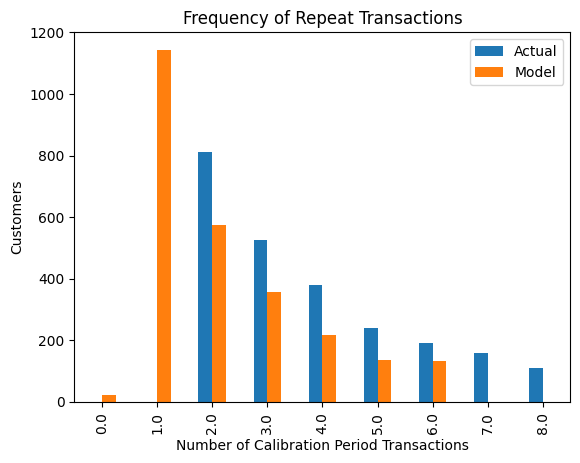

In [ ]:
plot_period_transactions(bgf)
plt.show()

# Gamma Gamma Modeli ile Beklenen Ortalama Kar

In [ ]:
ggf = GammaGammaFitter(penalizer_coef=0.01)

In [ ]:
ggf.fit(cltv_df['frequency'], cltv_df['monetary'])

<lifetimes.GammaGammaFitter: fitted with 2893 subjects, p: 3.79, q: 0.34, v: 3.73>

In [ ]:
ggf.conditional_expected_average_profit(cltv_df['frequency'],
                                        cltv_df['monetary']).head(10)

,0
Customer ID,
12346.00000,34.78545
12347.00000,726.75385
12349.00000,813.43000
12352.00000,190.32228
12356.00000,1261.84945
12357.00000,6172.34589
12358.00000,958.04822
12359.00000,436.16037
12360.00000,325.97172


In [ ]:
ggf.conditional_expected_average_profit(cltv_df['frequency'],
                                        cltv_df['monetary']).sort_values(ascending=False).head(10)

,0
Customer ID,
12357.00000,6172.34589
17450.00000,5457.78834
14091.00000,5022.92165
14088.00000,4792.19150
18102.00000,3533.39257
12409.00000,3228.01134
14646.00000,3115.76582
12454.00000,2940.28469
16684.00000,2866.37809


In [ ]:
cltv_df["expected_average_profit"] = ggf.conditional_expected_average_profit(cltv_df['frequency'],
                                                                             cltv_df['monetary'])

In [ ]:
cltv_df.sort_values("expected_average_profit", ascending=False).head(10)

,recency,T,frequency,monetary,expected_purc_1_week,expected_purc_1_month,expected_average_profit
Customer ID,,,,,,,
12357.00000,0.00000,7.93878,2,5633.46500,0.00047,0.00165,6172.34589
17450.00000,1.42857,8.95918,7,5321.58500,0.00003,0.00010,5457.78834
14091.00000,0.89796,14.26531,2,4584.04500,0.00028,0.00101,5022.92165
14088.00000,0.28571,8.61224,3,4512.99000,0.00017,0.00060,4792.19150
18102.00000,7.61224,15.08163,89,3526.44242,0.00000,0.00000,3533.39257
12409.00000,2.93878,11.55102,4,3086.65500,0.00233,0.00830,3228.01134
14646.00000,7.38776,15.06122,78,3108.76718,0.00000,0.00000,3115.76582
12454.00000,0.51020,8.61224,4,2811.44500,0.00008,0.00029,2940.28469
16684.00000,7.18367,14.95918,27,2847.76704,0.00000,0.00000,2866.37809


# 4. BG-NBD ve GG modeli ile CLTV'nin hesaplanması.

In [ ]:
cltv = ggf.customer_lifetime_value(bgf,
                                   cltv_df['frequency'],
                                   cltv_df['recency'],
                                   cltv_df['T'],
                                   cltv_df['monetary'],
                                   time=3,  # 3 aylık
                                   freq="W",  # T'nin frekans bilgisi.
                                   discount_rate=0.01)

In [ ]:
cltv_df.columns

Index(['recency', 'T', 'frequency', 'monetary', 'expected_purc_1_week', 'expected_purc_1_month', 'expected_average_profit'], dtype='object')

In [ ]:
cltv.head()

,clv
Customer ID,
12346.00000,0.00088
12347.00000,15.30393
12349.00000,68.65288
12352.00000,1.74518
12356.00000,8.78304


In [ ]:
cltv = cltv.reset_index()

In [ ]:
cltv_final = cltv_df.merge(cltv, on="Customer ID", how="left")

In [ ]:
cltv_final.sort_values(by="clv", ascending=False).head(10)

,Customer ID,recency,T,frequency,monetary,expected_purc_1_week,expected_purc_1_month,expected_average_profit,clv
67,12497.00000,4.97959,13.16327,2,2563.82000,0.02863,0.10435,2810.17976,744.27387
1671,15823.00000,7.30612,14.93878,3,1292.05000,0.04228,0.15451,1372.92548,540.73873
83,12557.00000,7.16327,14.75510,4,1681.29500,0.03109,0.11287,1758.73505,498.75645
1059,14564.00000,6.12245,15.02041,2,1302.81000,0.03023,0.11124,1429.00209,411.78533
6,12358.00000,7.26531,14.93878,3,901.23667,0.04139,0.15125,958.04822,369.36491
449,13373.00000,6.46939,14.97959,3,1424.98000,0.02597,0.09492,1514.04050,366.50870
2127,16732.00000,6.69388,14.93878,3,1175.27667,0.03013,0.11012,1248.96195,350.59885
58,12477.00000,4.55102,12.73469,3,2352.21000,0.01557,0.05619,2498.36372,348.53250
42,12435.00000,6.93878,15.06122,4,1460.22250,0.02348,0.08538,1527.60809,328.82233
221,12873.00000,5.79592,13.91837,2,826.65000,0.03546,0.12981,907.46653,301.60672


# 5. CLTV'ye Göre Segmentlerin Oluşturulması

In [ ]:
cltv_final["segment"] = pd.qcut(cltv_final["clv"], 4, labels=["D", "C", "B", "A"])

In [ ]:
cltv_final.sort_values(by="clv", ascending=False).head(50)

,Customer ID,recency,T,frequency,monetary,expected_purc_1_week,expected_purc_1_month,expected_average_profit,clv,segment
67,12497.00000,4.97959,13.16327,2,2563.82000,0.02863,0.10435,2810.17976,744.27387,A
1671,15823.00000,7.30612,14.93878,3,1292.05000,0.04228,0.15451,1372.92548,540.73873,A
83,12557.00000,7.16327,14.75510,4,1681.29500,0.03109,0.11287,1758.73505,498.75645,A
1059,14564.00000,6.12245,15.02041,2,1302.81000,0.03023,0.11124,1429.00209,411.78533,A
6,12358.00000,7.26531,14.93878,3,901.23667,0.04139,0.15125,958.04822,369.36491,A
449,13373.00000,6.46939,14.97959,3,1424.98000,0.02597,0.09492,1514.04050,366.50870,A
2127,16732.00000,6.69388,14.93878,3,1175.27667,0.03013,0.11012,1248.96195,350.59885,A
58,12477.00000,4.55102,12.73469,3,2352.21000,0.01557,0.05619,2498.36372,348.53250,A
42,12435.00000,6.93878,15.06122,4,1460.22250,0.02348,0.08538,1527.60809,328.82233,A
221,12873.00000,5.79592,13.91837,2,826.65000,0.03546,0.12981,907.46653,301.60672,A


In [ ]:
cltv_final.groupby("segment").agg(
    {"count", "mean", "sum"})

Customer ID                      recency                         T                  frequency              monetary                    expected_purc_1_week                expected_purc_1_month                expected_average_profit                         clv                  
               mean            sum count    mean        sum count     mean        sum count      mean   sum count      mean          sum count                 mean      sum count                  mean      sum count                    mean          sum count     mean         sum count
segment                                                                                                                                                                                                                                                                                      
D       15523.50691 11239019.00000   724 3.24586 2350.00000   724 12.55032 9086.42857   724  11.61740  8411   724 333.41426 241391.92228   724              0.00023  0.16957   724               0.00083  0.60225   724               344.63602 249516.47746   724  0.39473   285.78714   724
C       15306.85754 11066858.00000   723 3.32108 2401.14286   723 12.11709 8760.65306   723   5.09267  3682   723 330.47018 238929.94032   723              0.00182  1.31446   723               0.00648  4.68851   723               348.91695 252266.95787   723  3.86815  2796.67392   723
B       15349.73997 11097862.00000   723 4.33195 3132.00000   723 12.86414 9300.77551   723   4.43015  3203   723 368.43330 266377.27303   723              0.00648  4.68270   723               0.02329 16.83658   723               389.27390 281445.02681   723 15.59458 11274.87821   723
A       15223.04564 11006262.00000   723 5.40627 3908.73469   723 13.63217 9856.06122   723   3.45505  2498   723 464.48078 335819.60124   723              0.01914 13.83877   723               0.06952 50.26159   723               494.42994 357472.84645   723 74.02459 53519.77521   723